In [14]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston


from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")


import sklearn.linear_model as lm

import utilcompute as uc
from pprint import pprint

from sklearn.model_selection import KFold


In [15]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

print('df.shape[0] : ', df.shape[0])


df.shape[0] :  506


In [16]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [17]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [18]:
target = 'MEDV'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [19]:
# DATA PREPROCESSING : features standardization

df_std = uc.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
pprint(vif_dict)


{'AGE': 3.1008597090649377,
 'B': 1.3458321362245256,
 'CHAS': 1.073942576235468,
 'CRIM': 1.7733207336404873,
 'DIS': 3.9565506707875113,
 'INDUS': 3.9911944587426742,
 'LSTAT': 2.9381269138596409,
 'NOX': 4.3950638803302251,
 'PTRATIO': 1.7992202856110953,
 'RAD': 7.48053920326217,
 'RM': 1.9341610244158234,
 'TAX': 9.0084721742418967,
 'ZN': 2.2986411129153459}


In [20]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [21]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['AGE' 'B' 'CHAS' 'CRIM' 'DIS' 'INDUS' 'LSTAT' 'MEDV' 'NOX' 'PTRATIO' 'RAD'
 'RM' 'TAX' 'ZN']


In [22]:
# GLOBAL PARAMETERS 

train_perc = 0.8
delimiter = int(len(df) * train_perc)
seeds = range(1, 50 + 1)

n_splits = int(1 / (1 - train_perc))

print('train fold size   : ', delimiter)
print('test  fold size   : ', (len(df) - delimiter))
print('n_splits in k fold cv : ', n_splits)
print()
print('seeds : {0} ... {1}'.format(seeds[0], seeds[-1]))


train fold size   :  404
test  fold size   :  102
n_splits in k fold cv :  5

seeds : 1 ... 50


In [23]:
# REPEATED HOLD-OUT VALIDATION 

# description :

# we take our dataset and repeatedly shuffle it in a random fashion, 
# at each iteration we split the shuffled dataset in two parts: a training set and a test set,
# then we fit a model to the training data and predict the labels of the test set,
# save the error metrics, and average the results

# basically we are going to repeat the hold out method k times, each time with a different random seed, 
# the goal is to obtain a more robust (stable) estimate that is less variant to how we split the data


# ----------------------------------------------------------------------------------------------------------------------------- #


scores_train = []
scores_test = []

for (s_index, s) in enumerate(seeds):
    np.random.seed(s)
    df_shuffled = df.reindex(np.random.permutation(df.index))    
    
    train = df_shuffled[:delimiter]
    test = df_shuffled[delimiter:]
    
    #if (s_index == 0):
    #    print('df_shuffled indices : {0} ... {1}'.format(df_shuffled.index.values[:3], df_shuffled.index.values[-3:]))     
    #    print('train set/fold size : ', len(train))
    #    print('test  set/fold size : ', len(test))
    #    print()
    #    print('train : {0} - {1}'.format(train.index.values.tolist()[:3], train.index.values[-3:]))
    #    print('test  : {0} - {1}'.format(test.index.values.tolist()[:3], test.index.values[-3:]))
    #    print()
    
    model = lm.LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
    model.fit(train[features], train[target])
    
    y_pred_train = model.predict(train[features])
    y_pred_test = model.predict(test[features])
    
    metrics_train = uc.compute_regression_metrics(y = train[target], y_pred = y_pred_train)
    metrics_test = uc.compute_regression_metrics(y = test[target], y_pred = y_pred_test)
    
    scores_train.append(metrics_train['MSE'])
    scores_test.append(metrics_test['MSE'])
    

In [24]:
# K-FOLD CROSS VALIDATION

# description :

# k-fold cross-validation is a special case of cross-validation where we split the data
# into K parts (or 'folds') and iterate over our data K times; 

# in each iteration the k-th fold is used for validation, 
# and the remaining k-1 folds are merged into a training subset


# ----------------------------------------------------------------------------------------------------------------------------- #


columns = ['seed', 'iteration', 'mse_train', 'mse_test']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

for (s_index, s) in enumerate(seeds):
    np.random.seed(s)
    df_shuffled = df.reindex(np.random.permutation(df.index))    
    
    #if (s_index == 0):
    #    print('df_shuffled indices : {0} ... {1}'.format(df_shuffled.index.values[:3], df_shuffled.index[-3:]))
    
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)
    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df_shuffled[features], y = df_shuffled[target])) :
        
        #if (s_index == 0):
        #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
        #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
        #    print()
            
        fold_train = df_shuffled.iloc[train_positions]   
        fold_test = df_shuffled.iloc[test_positions]     
        
        model = lm.LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)
        model.fit(fold_train[features], fold_train[target])
        
        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])
    
        metrics_train = uc.compute_regression_metrics(y = fold_train[target], y_pred = y_pred_train)
        metrics_test = uc.compute_regression_metrics(y = fold_test[target], y_pred = y_pred_test)
        
        values_dict = {
            'seed' : s,
            'iteration' : k,            
            'mse_train' : metrics_train['MSE'],
            'mse_test' : metrics_test['MSE'],
        }
        
        results_index = (n_splits * s_index) + k
        results_df.loc[results_index] = values_dict     

results_df = results_df.astype(dtype = 'float')
#print(results_df)


k fold cv | train | mse mean :  21.67960755392186
k fold cv | train | mse std  :  1.3207176729035444

k fold cv | test  | mse mean :  23.934092748792914
k fold cv | test  | mse std  :  5.67734184555713


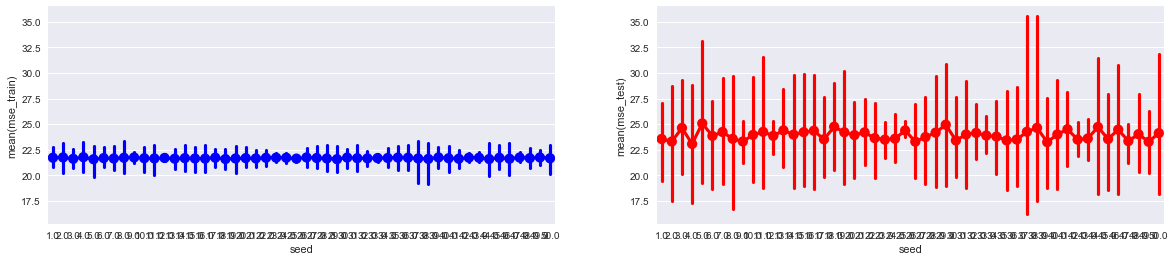

In [25]:
print('k fold cv | train | mse mean : ', results_df['mse_train'].mean())
print('k fold cv | train | mse std  : ', results_df['mse_train'].std())

print()
print('k fold cv | test  | mse mean : ', results_df['mse_test'].mean())
print('k fold cv | test  | mse std  : ', results_df['mse_test'].std())

fig, axs = plt.subplots(nrows = 1, ncols = 2 , figsize=(20, 4))  

sns.pointplot(x = 'seed', y = 'mse_train', data = results_df, join = True, color = 'blue', ax = axs[0])
sns.pointplot(x = 'seed', y = 'mse_test', data = results_df, join = True, color = 'red', ax = axs[1])

y_lim = (0,0)
max_y_range = y_lim[1] - y_lim[0]
for ax in axs:
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    if (y_range > max_y_range):
        max_y_range = y_range
        y_lim = ax.get_ylim()

for ax in axs:   
    ax.set_ylim(y_lim)

plt.show()


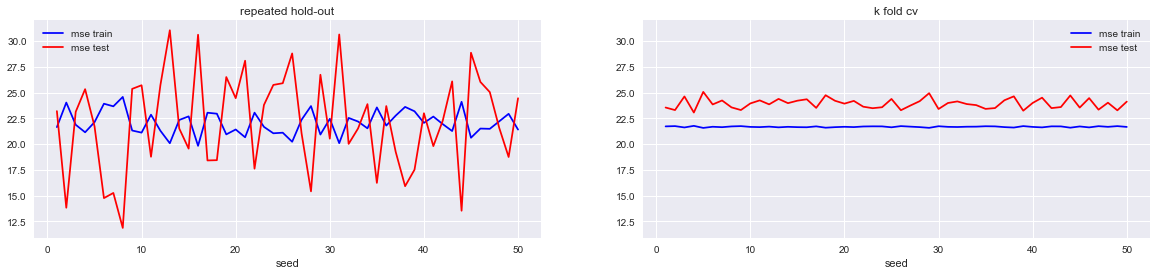

In [28]:
# COMPARISON

fig, axs = plt.subplots(nrows = 1, ncols = 2 , figsize=(20, 4))  

axs[0].plot(seeds, scores_train, color = 'blue', label = 'mse train')
axs[0].plot(seeds, scores_test, color = 'red', label = 'mse test')

axs[0].set_xlabel('seed')
axs[0].legend()
axs[0].set_title('repeated hold-out')


results_grouped = results_df[['seed','mse_train', 'mse_test']].groupby(by = 'seed', axis = 0, as_index = False)

axs[1].plot(seeds, results_grouped.mean()['mse_train'], color = 'blue', label = 'mse train')
axs[1].plot(seeds, results_grouped.mean()['mse_test'], color = 'red', label = 'mse test')

axs[1].set_xlabel('seed')
axs[1].legend()
axs[1].set_title('k fold cv')

y_lim = (0,0)
max_y_range = y_lim[1] - y_lim[0]
for ax in axs:
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    if (y_range > max_y_range):
        max_y_range = y_range
        y_lim = ax.get_ylim()
axs[1].set_ylim(y_lim)

plt.show()


In [27]:
# CONCLUSIONS

# 1) choice of the test set size :
#    a good compromise is usually 20% of the original dataset

# 2) having chosen a good test size will not protect us from the effects
#    of the distribution of data-points between training and test set, the data in the test set 
#    (and therefore also in the training set) should change across iterations

# 3) distribution of the data within training and test set :
#    it seems that k-fold cross validation effectively works in mitigating the magnitude of this issue;
#    we did not try to create more representative splits, but we realized that by running hold-out multiple times
#    with different folds, we could have mitigated the anomalies in the results by averaging the latter.

# 4) hold out validation works with a training (and consequently test) set 
#    that most likely is not representative of the original dataframe,
#    and leads to unreliable estimates of both in-sample and out-of-sample prediction error.

# 4) a common value for K is 5 or 10

# NOTE : see <4 - k fold cv>
